In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
image_set =  "lung_image_sets"

In [3]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [4]:
IMAGE_SIZE = [224, 224]

In [5]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

2023-02-12 20:01:58.219381: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 1s 0us/step


In [6]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [7]:
flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)

In [8]:
#creating a model
model = Model(inputs = resnet.input, outputs = prediction )

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
# COMPILING THE MODEL

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [11]:
#executing the model
history = model.fit_generator(train_set, validation_data = (validate_set), epochs = 5, verbose = 1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-12 20:04:35.685056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
94/94 [==============================] - 1127s 12s/step - loss: 4.6412 - accuracy: 0.7848 - val_loss: 0.2003 - val_accuracy: 0.9597
Epoch 2/5
94/94 [==============================] - 1107s 12s/step - loss: 0.5464 - accuracy: 0.9278 - val_loss: 0.1990 - val_accuracy: 0.9577
Epoch 3/5
94/94 [==============================] - 1100s 12s/step - loss: 0.0878 - accuracy: 0.9756 - val_loss: 0.2943 - val_accuracy: 0.9307
Epoch 4/5
94/94 [==============================] - 1101s 12s/step - loss: 0.0426 - accuracy: 0.9843 - val_loss: 0.0745 - val_accuracy: 0.9813
Epoch 5/5
94/94 [==============================] - 1106s 12s/step - loss: 0.0188 - accuracy: 0.9919 - val_loss: 0.0476 - val_accuracy: 0.9857


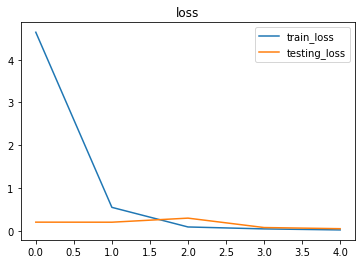

In [12]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

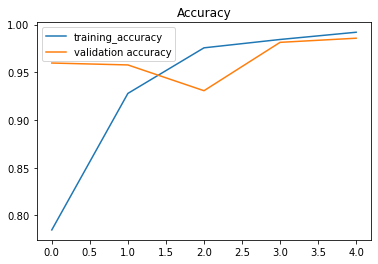

In [13]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [14]:
# CHECKING THE CONFUSION MATRIX

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict_generator(validate_set)
y_pred = np.argmax(Y_pred ,axis =1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(validate_set.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['aca','n', 'scc']
print(classification_report(validate_set.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[970   1  29]
 [  2 998   0]
 [ 11   0 989]]
Classification Report
              precision    recall  f1-score   support

         aca       0.99      0.97      0.98      1000
           n       1.00      1.00      1.00      1000
         scc       0.97      0.99      0.98      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [15]:
result = model.evaluate(validate_set,batch_size=128)
print("test_loss, test accuracy",result)

24/24 [==============================] - 220s 9s/step - loss: 0.0476 - accuracy: 0.9857
test_loss, test accuracy [0.04755670577287674, 0.9856666922569275]
